<a href="https://colab.research.google.com/github/yukismd/DL_for_ImageData_and_Finetuning/blob/main/tutorials/text_classification_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using HuggingFace transformers

参考：
- https://huggingface.co/docs/transformers/ja/training
- https://huggingface.co/docs/transformers/tasks/sequence_classification

利用モデル
- https://huggingface.co/line-corporation/line-distilbert-base-japanese
- https://huggingface.co/line-corporation/line-distilbert-base-japanese/blob/main/config.json

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 27.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [4]:
!pip install fugashi sentencepiece unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=e4b5502ce40e461181e94760e8853d46d60c25df0c3cd3aedf33d8e9ceb76972
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


In [6]:
import datasets
print(datasets.__version__)
import transformers
print(transformers.__version__)
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler

import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

2.19.0
4.40.0


In [9]:
df = pd.read_csv('./tmp/amazon_review_sample1k.csv')
print(df.shape)
df.sample(10)

(1000, 3)


,text,rating,label
871,さて、人間誰しも何かに囚われて生きているものだ。 それは主に多感な時期に、遭遇した経験...,5,0
696,映画を見ずに、この本から購入し、先日ＤＶＤを購入しました。子供は、本の絵を見て、話をＣＤで聞...,5,0
246,NETで商品を見たときはCOLOR版であったが、届いた商品は白黒。,1,1
714,英語か分からなくても、写真が多くて、とても理解しやすいです。こんなに、多くの種類があるなんて...,5,0
486,映画化されると思っていなかったので公開前に小説を読んでみたい気になり購入しました。本人の写真...,5,0
2,いまは毎日勉強していて、わかりやすく書かれていて、とても満足しています。,5,0
219,この本のおかげで毎日の習慣が私の中で180度変わろうとしています。 今まで当たり前にしてきた...,5,0
767,19-22の日本語音声ミス、22の日本語字幕ミスは過去レビュー見てわかった上で買いました。英...,3,1
298,今流行りの英字絵本です。他にも色々なバージョンがあるみたいで、集めるのもいいかも。,4,0
36,感謝ワーク効きますよ！今まで起こらなかった変化が起こっています。習慣にすると、落ち込んだ時に...,5,0


In [10]:
df['label'].value_counts()

label
0    850
1    150
Name: count, dtype: int64

-  label=1 : ratingが3以下（Negative）
-  label=0 : ratingが4以上（Positive）

In [11]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=123)
df_train.shape, df_test.shape

((800, 3), (200, 3))

### datasets.Datasetの準備

In [12]:
# 直接csvを読み込む場合
datasets.load_dataset('csv', data_files=['./tmp/amazon_review_sample1k.csv'])

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'rating', 'label'],
        num_rows: 1000
    })
})

In [13]:
# pandasから変換
dataset_train = datasets.Dataset.from_pandas(df_train[['text','label']], preserve_index=False)
dataset_train

Dataset({
    features: ['text', 'label'],
    num_rows: 800
})

In [14]:
type(dataset_train)

datasets.arrow_dataset.Dataset

In [15]:
dataset_train['text'][0]

'全編英語だけど絵が多いので英語苦手な人でも作れると思いますが、もちろん\x08細かく細かく全てのステップの図解が載っている訳ではないので自己責任でご購入を検討してくださいませ。すごく沢山の種類が載っておりかなり楽しめました。一生のバイブルになるでしょう。'

In [16]:
dataset_train['label'][0]

0

In [17]:
dataset_test = datasets.Dataset.from_pandas(df_test[['text','label']], preserve_index=False)
dataset_test

Dataset({
    features: ['text', 'label'],
    num_rows: 200
})

### Tokenizerの適用

Tokenizerに関して: https://huggingface.co/docs/transformers/ja/tokenizer_summary

In [18]:
tokenizer = AutoTokenizer.from_pretrained('line-corporation/line-distilbert-base-japanese')
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/439k [00:00<?, ?B/s]

BertJapaneseTokenizer(name_or_path='line-corporation/line-distilbert-base-japanese', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [19]:
type(tokenizer)

transformers.models.bert_japanese.tokenization_bert_japanese.BertJapaneseTokenizer

https://huggingface.co/transformers/v4.11.3/_modules/transformers/models/bert_japanese/tokenization_bert_japanese.html

In [20]:
dataset_train['text'][0], dataset_train['label'][0]

('全編英語だけど絵が多いので英語苦手な人でも作れると思いますが、もちろん\x08細かく細かく全てのステップの図解が載っている訳ではないので自己責任でご購入を検討してくださいませ。すごく沢山の種類が載っておりかなり楽しめました。一生のバイブルになるでしょう。',
 0)

In [21]:
tokenizer(dataset_train['text'][0])

{'input_ids': [2, 180, 10807, 1685, 47, 524, 1749, 14, 621, 5, 9, 1685, 5231, 16, 54, 9, 20, 124, 368, 15, 318, 39, 14, 6, 1784, 10234, 13016, 10143, 10143, 1363, 5, 4487, 5, 788, 10611, 14, 10039, 12, 42, 3031, 9, 10, 50, 5, 9, 2593, 2767, 9, 162, 949, 13, 2678, 17, 12, 525, 231, 8, 3947, 5442, 5, 1551, 14, 10039, 12, 282, 1546, 7365, 70, 11, 8, 6202, 5, 2191, 774, 7, 136, 502, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
len(tokenizer(dataset_train['text'][0])['input_ids'])

79

In [23]:
tokenizer.decode(
    tokenizer(dataset_train['text'][0])['input_ids']
)

'全編 英語 だ けど 絵 が 多い の で 英語 苦手 な 人 で も 作れる と 思い ます が 、 もちろん \x08 細かく 細かく 全て の ステップ の 図解 が 載っ て いる 訳 で は ない の で 自己 責任 で ご 購入 を 検討 し て ください ませ 。 すごく 沢山 の 種類 が 載っ て おり かなり 楽しめ まし た 。 一生 の バイブル に なる でしょう 。'

In [24]:
# トークン化
tokenizer.tokenize(dataset_train['text'][0])

['▁全',
 '編',
 '▁英語',
 '▁だ',
 '▁けど',
 '▁絵',
 '▁が',
 '▁多い',
 '▁の',
 '▁で',
 '▁英語',
 '▁苦手',
 '▁な',
 '▁人',
 '▁で',
 '▁も',
 '▁作',
 'れる',
 '▁と',
 '▁思い',
 '▁ます',
 '▁が',
 '▁、',
 '▁もちろん',
 '▁',
 '\x08',
 '▁細かく',
 '▁細かく',
 '▁全て',
 '▁の',
 '▁ステップ',
 '▁の',
 '▁図',
 '解',
 '▁が',
 '▁載っ',
 '▁て',
 '▁いる',
 '▁訳',
 '▁で',
 '▁は',
 '▁ない',
 '▁の',
 '▁で',
 '▁自己',
 '▁責任',
 '▁で',
 '▁ご',
 '▁購入',
 '▁を',
 '▁検討',
 '▁し',
 '▁て',
 '▁ください',
 '▁ませ',
 '▁。',
 '▁すごく',
 '▁沢山',
 '▁の',
 '▁種類',
 '▁が',
 '▁載っ',
 '▁て',
 '▁おり',
 '▁かなり',
 '▁楽しめ',
 '▁まし',
 '▁た',
 '▁。',
 '▁一生',
 '▁の',
 '▁バイ',
 'ブル',
 '▁に',
 '▁なる',
 '▁でしょう',
 '▁。']

In [25]:
len(tokenizer.tokenize(dataset_train['text'][0]))

77

In [26]:
# トークンのID変換
tokenizer.convert_tokens_to_ids(
    tokenizer.tokenize(dataset_train['text'][0])
)

[180,
 10807,
 1685,
 47,
 524,
 1749,
 14,
 621,
 5,
 9,
 1685,
 5231,
 16,
 54,
 9,
 20,
 124,
 368,
 15,
 318,
 39,
 14,
 6,
 1784,
 10234,
 13016,
 10143,
 10143,
 1363,
 5,
 4487,
 5,
 788,
 10611,
 14,
 10039,
 12,
 42,
 3031,
 9,
 10,
 50,
 5,
 9,
 2593,
 2767,
 9,
 162,
 949,
 13,
 2678,
 17,
 12,
 525,
 231,
 8,
 3947,
 5442,
 5,
 1551,
 14,
 10039,
 12,
 282,
 1546,
 7365,
 70,
 11,
 8,
 6202,
 5,
 2191,
 774,
 7,
 136,
 502,
 8]

In [27]:
# 特殊トークンの付与
tokenizer.prepare_for_model(
    tokenizer.convert_tokens_to_ids(
        tokenizer.tokenize(dataset_train['text'][0])
    )
)

{'input_ids': [2, 180, 10807, 1685, 47, 524, 1749, 14, 621, 5, 9, 1685, 5231, 16, 54, 9, 20, 124, 368, 15, 318, 39, 14, 6, 1784, 10234, 13016, 10143, 10143, 1363, 5, 4487, 5, 788, 10611, 14, 10039, 12, 42, 3031, 9, 10, 50, 5, 9, 2593, 2767, 9, 162, 949, 13, 2678, 17, 12, 525, 231, 8, 3947, 5442, 5, 1551, 14, 10039, 12, 282, 1546, 7365, 70, 11, 8, 6202, 5, 2191, 774, 7, 136, 502, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [28]:
def tokenize_function(examples):
    #return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"], truncation=True, max_length=512)   # max_length=512はモデルのmax_position_embeddings

# truncation=True -> max_lengthの長さに切り詰め

Padding, Truncationに関して: https://huggingface.co/docs/transformers/ja/pad_truncation

In [29]:
tokenized_datasets_train = dataset_train.map(tokenize_function, batched=True)
tokenized_datasets_train

Parameter 'function'=<function tokenize_function at 0x7e44de321900> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 800
})

In [30]:
tokenized_datasets_test = dataset_test.map(tokenize_function, batched=True)
tokenized_datasets_test

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})

In [31]:
type(tokenized_datasets_train[0])

dict

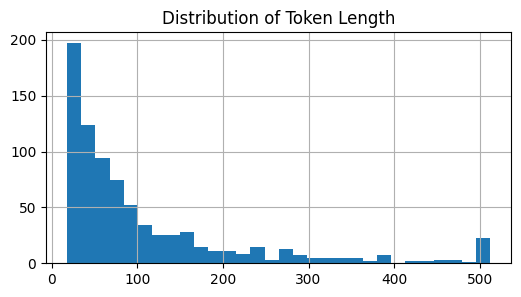

In [32]:
plt.figure(figsize=(6, 3))
pd.Series([len(i) for i in tokenized_datasets_train['input_ids']]).hist(bins=30)
plt.title('Distribution of Token Length')
plt.show()

In [33]:
# textカラムの削除
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['text'])
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['text'])

In [34]:
# token_type_idsカラムの削除
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['token_type_ids'])
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['token_type_ids'])

DistilBERT doesn’t have token_type_ids: https://huggingface.co/docs/transformers/model_doc/distilbert#usage-tips

In [35]:
# labelカラムをlabelsへリネーム
tokenized_datasets_train = tokenized_datasets_train.rename_column('label', 'labels')
tokenized_datasets_test = tokenized_datasets_test.rename_column('label', 'labels')

In [36]:
tokenized_datasets_train

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 800
})

In [37]:
tokenized_datasets_test

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [38]:
# tensor型に変換
tokenized_datasets_train.set_format("torch")
tokenized_datasets_test.set_format("torch")

In [39]:
tokenized_datasets_train[0]

{'labels': tensor(0),
 'input_ids': tensor([    2,   180, 10807,  1685,    47,   524,  1749,    14,   621,     5,
             9,  1685,  5231,    16,    54,     9,    20,   124,   368,    15,
           318,    39,    14,     6,  1784, 10234, 13016, 10143, 10143,  1363,
             5,  4487,     5,   788, 10611,    14, 10039,    12,    42,  3031,
             9,    10,    50,     5,     9,  2593,  2767,     9,   162,   949,
            13,  2678,    17,    12,   525,   231,     8,  3947,  5442,     5,
          1551,    14, 10039,    12,   282,  1546,  7365,    70,    11,     8,
          6202,     5,  2191,   774,     7,   136,   502,     8,     3]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])}

In [40]:
type(tokenized_datasets_train[0]['labels'])

torch.Tensor

### Dataloder

In [41]:
tokenizer

BertJapaneseTokenizer(name_or_path='line-corporation/line-distilbert-base-japanese', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [42]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest", max_length=512)
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=512)

Collator: https://huggingface.co/docs/transformers/ja/main_classes/data_collator  
- ミニバッチ単位で長さを揃える（Padding）機能

In [44]:
batch_size = 16

train_dataloader = DataLoader(tokenized_datasets_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_datasets_test, batch_size=batch_size, collate_fn=data_collator)

In [45]:
train_dataloader

In [46]:
train_dataloader.collate_fn

DataCollatorWithPadding(tokenizer=BertJapaneseTokenizer(name_or_path='line-corporation/line-distilbert-base-japanese', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True)

In [47]:
len(train_dataloader), len(eval_dataloader)

(50, 13)

In [48]:
800/batch_size, 200/batch_size

(50.0, 12.5)

### Model

In [49]:
model = AutoModelForSequenceClassification.from_pretrained('line-corporation/line-distilbert-base-japanese', num_labels=2)

config.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/275M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at line-corporation/line-distilbert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

https://huggingface.co/docs/transformers/v4.14.1/model_doc/distilbert#transformers.DistilBertForSequenceClassification

In [51]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(32768, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [52]:
model.config

DistilBertConfig {
  "_name_or_path": "line-corporation/line-distilbert-base-japanese",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": true,
  "tie_weights_": true,
  "transformers_version": "4.40.0",
  "vocab_size": 32768
}

In [53]:
# Model check
# (batch size, token length)
sample_out = model(
    input_ids=torch.zeros((4, 15), dtype=torch.int),
    attention_mask=torch.zeros((4, 15), dtype=torch.int)
)
#sample_out

In [54]:
len(sample_out)

2

In [55]:
sample_out[0]

tensor([[-0.4624,  0.1623],
        [-0.4624,  0.1623],
        [-0.4624,  0.1623],
        [-0.4624,  0.1623]], grad_fn=<AddmmBackward0>)

In [56]:
# logitでのアウトプット
sample_out.logits

tensor([[-0.4624,  0.1623],
        [-0.4624,  0.1623],
        [-0.4624,  0.1623],
        [-0.4624,  0.1623]], grad_fn=<AddmmBackward0>)

In [57]:
# max index
torch.argmax(sample_out.logits, dim=-1)

tensor([1, 1, 1, 1])

In [58]:
sample_out.logits.shape

torch.Size([4, 2])

In [59]:
#sample_out[1]

In [60]:
#sample_out.hidden_states

In [61]:
len(sample_out.hidden_states)

7

In [62]:
for i in range(len(sample_out.hidden_states)):
    print(sample_out.hidden_states[i].shape, sample_out[1][i].mean(), sample_out[1][i].std())

torch.Size([4, 15, 768]) tensor(-0.0163, grad_fn=<MeanBackward0>) tensor(0.7592, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(-0.0044, grad_fn=<MeanBackward0>) tensor(0.5720, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(-0.0038, grad_fn=<MeanBackward0>) tensor(0.7768, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(-0.0017, grad_fn=<MeanBackward0>) tensor(0.7886, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(0.0037, grad_fn=<MeanBackward0>) tensor(0.8767, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(0.0016, grad_fn=<MeanBackward0>) tensor(0.8713, grad_fn=<StdBackward0>)
torch.Size([4, 15, 768]) tensor(-0.0112, grad_fn=<MeanBackward0>) tensor(0.8957, grad_fn=<StdBackward0>)


### Optimizer, Scheduler

In [63]:
model.parameters()

<generator object Module.parameters at 0x7e44d547f140>

In [64]:
optimizer = AdamW(model.parameters(), lr=5e-5)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0.01
)

In [65]:
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
print(len(train_dataloader), num_training_steps)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
lr_scheduler

50 100


### Training

In [66]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [67]:
train_dataloader

In [68]:
progress_bar = tqdm(range(num_training_steps))

model.to(device)
model.train()

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    for batch in train_dataloader:
        #print(batch.keys())
        #print("input_ids shape: ", batch['input_ids'].shape)
        #print("attention_mask shape: ", batch['attention_mask'].shape)
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/2
Epoch: 2/2
